In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("../../../data/data_taxi_central_based.parquet")
df = df[df['POLYLINE_LENGTH'] == 41]
df

,TRIP_ID,ORIGIN_CALL,TAXI_ID,TIMESTAMP,POLYLINE_LENGTH,LON,LAT
index,,,,,,,
1284,1372638793620000571,2002.0,20000571,1372638793,41,-8.574705,41.142717
1285,1372638793620000571,2002.0,20000571,1372638808,41,-8.574696,41.142726
1286,1372638793620000571,2002.0,20000571,1372638823,41,-8.574687,41.142726
1287,1372638793620000571,2002.0,20000571,1372638838,41,-8.574678,41.142708
1288,1372638793620000571,2002.0,20000571,1372638853,41,-8.574687,41.142708
...,...,...,...,...,...,...,...
83401453,1404155073620000099,4690.0,20000099,1404155613,41,-8.620533,41.145957
83401454,1404155073620000099,4690.0,20000099,1404155628,41,-8.620542,41.145957
83401455,1404155073620000099,4690.0,20000099,1404155643,41,-8.619741,41.146119


In [3]:
import timesfm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)].


In [4]:
df_lon = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LAT'])
df_lat = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LON'])

In [5]:
tfm_lat = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=10,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
tfm_lon = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=10,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
df_lat = df_lat.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lat_test = df_lat.groupby('TRIP_ID', group_keys=False).tail(10)
df_lat_train = df_lat.drop(df_lat_test.index)

In [8]:
df_lon = df_lon.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lon_test = df_lon.groupby('TRIP_ID', group_keys=False).tail(10)
df_lon_train = df_lon.drop(df_lat_test.index)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler_lat = MinMaxScaler()
df_lat_train['LAT'] = scaler_lat.fit_transform(df_lat_train[['LAT']])

scaler_lon = MinMaxScaler()
df_lon_train['LON'] = scaler_lon.fit_transform(df_lon_train[['LON']])

In [10]:
df_lat_train['TIMESTAMP'] = pd.to_datetime(df_lat_train['TIMESTAMP'], unit='s')
df_lon_train['TIMESTAMP'] = pd.to_datetime(df_lon_train['TIMESTAMP'], unit='s')

In [11]:
df_lon_train = df_lon_train.rename(columns={'TIMESTAMP': 'ds', 'LON': 'y', 'TRIP_ID': 'unique_id'})
df_lat_train = df_lat_train.rename(columns={'TIMESTAMP': 'ds', 'LAT': 'y', 'TRIP_ID': 'unique_id'})

In [12]:
forecast_df_lon = tfm_lon.forecast_on_df(
    inputs=df_lon_train,
    freq="15s",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [13]:
forecast_df_lat = tfm_lon.forecast_on_df(
    inputs=df_lat_train,
    freq="15s",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [14]:
forecast_df_lon_keep = forecast_df_lon[['unique_id', 'ds', 'timesfm-q-0.9']]

In [15]:
forecast_df_lat_keep = forecast_df_lat[['unique_id', 'ds', 'timesfm-q-0.9']]

In [16]:
forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])

C:\Users\Nikola\AppData\Local\Temp\ipykernel_13204\3587103272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
C:\Users\Nikola\AppData\Local\Temp\ipykernel_13204\3587103272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])


In [17]:
forecast_df_lat_keep = forecast_df_lat_keep.rename(columns={'timesfm-q-0.9': 'LAT_PREDICTED'})
forecast_df_lon_keep = forecast_df_lon_keep.rename(columns={'timesfm-q-0.9': 'LON_PREDICTED'})

In [18]:
forecast_df_lat_keep = forecast_df_lat_keep.sort_values(['unique_id', 'ds'])
forecast_df_lat_keep = forecast_df_lat_keep.groupby('unique_id').tail(1)

forecast_df_lon_keep = forecast_df_lon_keep.sort_values(['unique_id', 'ds'])
forecast_df_lon_keep = forecast_df_lon_keep.groupby('unique_id').tail(1)

In [19]:
df_lon_test = df_lon_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lon_test = df_lon_test.sort_values(['unique_id', 'ds'])
df_lon_test = df_lon_test.groupby('unique_id').tail(1)

df_lat_test = df_lat_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lat_test = df_lat_test.sort_values(['unique_id', 'ds'])
df_lat_test = df_lat_test.groupby('unique_id').tail(1)

In [20]:
result_lat = df_lat_test.merge(forecast_df_lat_keep, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon_keep, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [21]:
from evaluation_script import haversine_distance

In [22]:
result['DISTANCE_DELTA_SEPARATED'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row['LAT_PREDICTED'], row['LON_PREDICTED']), axis=1)

In [23]:
result['DISTANCE_DELTA_SEPARATED'].mean()

np.float64(1.174080572161774)

In [24]:
result['DISTANCE_DELTA_SEPARATED'].median()

np.float64(1.0002941431512482)

In [25]:
result.to_csv("result.csv", index=False)

In [26]:
forecast_df_lat

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1372638793620000571,2013-07-01 00:40:58,0.331735,0.329185,0.330396,0.330870,0.331252,0.331735,0.332477,0.333558,0.334935,0.337228
1,1372638793620000571,2013-07-01 00:41:13,0.332792,0.328121,0.330296,0.331164,0.332001,0.332792,0.333842,0.335453,0.337249,0.339932
2,1372638793620000571,2013-07-01 00:41:28,0.333953,0.326833,0.329901,0.331493,0.332785,0.333953,0.335297,0.337187,0.339264,0.342113
3,1372638793620000571,2013-07-01 00:41:43,0.335331,0.326580,0.330419,0.332463,0.333943,0.335331,0.336834,0.338767,0.340811,0.343698
4,1372638793620000571,2013-07-01 00:41:58,0.337362,0.327432,0.331884,0.334211,0.335928,0.337362,0.338904,0.340857,0.342681,0.345436
...,...,...,...,...,...,...,...,...,...,...,...,...
68235,1404157914620000488,2014-06-30 20:00:54,0.505811,0.476810,0.488345,0.495281,0.500878,0.505811,0.510763,0.516350,0.522260,0.530625
68236,1404157914620000488,2014-06-30 20:01:09,0.506427,0.475028,0.487511,0.494978,0.501048,0.506427,0.511782,0.517802,0.524195,0.532840
68237,1404157914620000488,2014-06-30 20:01:24,0.506263,0.472467,0.486033,0.493980,0.500534,0.506263,0.511904,0.518263,0.524967,0.533708
68238,1404157914620000488,2014-06-30 20:01:39,0.506701,0.470322,0.485071,0.493643,0.500588,0.506701,0.512670,0.519295,0.526171,0.535090


In [27]:
columns = ['timesfm-q-0.1', 'timesfm-q-0.2', 'timesfm-q-0.3', 'timesfm-q-0.4', 'timesfm-q-0.5', 'timesfm-q-0.6', 'timesfm-q-0.7', 'timesfm-q-0.8', 'timesfm-q-0.9']

In [28]:
for column in columns:
    forecast_df_lat[column] = scaler_lat.inverse_transform(forecast_df_lat[[column]])
    forecast_df_lon[column] = scaler_lon.inverse_transform(forecast_df_lon[[column]])

In [29]:
forecast_df_lat = forecast_df_lat.sort_values(['unique_id', 'ds'])
forecast_df_lat = forecast_df_lat.groupby('unique_id').tail(1)

forecast_df_lon = forecast_df_lon.sort_values(['unique_id', 'ds'])
forecast_df_lon = forecast_df_lon.groupby('unique_id').tail(1)

In [30]:
result_lat = df_lat_test.merge(forecast_df_lat, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [31]:
result

,unique_id,ds_x_x,LAT,ds_y_x,timesfm_x,timesfm-q-0.1_x,timesfm-q-0.2_x,timesfm-q-0.3_x,timesfm-q-0.4_x,timesfm-q-0.5_x,...,timesfm_y,timesfm-q-0.1_y,timesfm-q-0.2_y,timesfm-q-0.3_y,timesfm-q-0.4_y,timesfm-q-0.5_y,timesfm-q-0.6_y,timesfm-q-0.7_y,timesfm-q-0.8_y,timesfm-q-0.9_y
0,1372638793620000571,1372639393,41.142636,2013-07-01 00:43:13,0.345431,41.141254,41.142296,41.142868,41.143261,41.143547,...,0.405764,-8.641284,-8.636547,-8.633628,-8.631207,-8.628679,-8.625636,-8.621869,-8.616815,-8.608926
1,1372641068620000178,1372641668,41.124366,2013-07-01 01:21:08,0.212926,41.116901,41.119637,41.121231,41.122337,41.123302,...,0.529034,-8.608447,-8.607171,-8.606368,-8.605744,-8.605149,-8.604590,-8.603975,-8.603275,-8.602176
2,1372656887620000167,1372657487,41.150844,2013-07-01 05:44:47,0.387592,41.145706,41.147312,41.148319,41.149162,41.149986,...,0.192813,-8.681437,-8.676126,-8.673088,-8.671062,-8.669328,-8.667459,-8.665147,-8.661880,-8.656393
3,1372657987620000623,1372658587,41.154570,2013-07-01 06:03:07,0.498290,41.158703,41.161804,41.163734,41.165386,41.166904,...,0.220539,-8.671474,-8.668164,-8.666455,-8.665264,-8.664035,-8.662571,-8.660479,-8.657239,-8.652020
4,1372660930620000571,1372661530,41.120118,2013-07-01 06:52:10,0.179246,41.104908,41.109665,41.112713,41.115482,41.118156,...,0.580279,-8.611526,-8.605657,-8.601750,-8.598458,-8.595367,-8.592402,-8.589149,-8.585755,-8.581001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,1404155056620000206,1404155656,41.151906,2014-06-30 19:14:16,0.403535,41.151909,41.152069,41.152195,41.152298,41.152428,...,0.467723,-8.624367,-8.621070,-8.619102,-8.617848,-8.616853,-8.616142,-8.615449,-8.614414,-8.612700
6820,1404155073620000099,1404155673,41.146920,2014-06-30 19:14:33,0.352169,41.142075,41.143044,41.143661,41.144146,41.144581,...,0.446403,-8.622550,-8.622005,-8.621600,-8.621249,-8.620922,-8.620641,-8.620367,-8.620074,-8.619659
6821,1404155819620000242,1404156419,41.171085,2014-06-30 19:26:59,0.533000,41.161255,41.165176,41.167927,41.170231,41.172207,...,0.523873,-8.631377,-8.621357,-8.614936,-8.610050,-8.606134,-8.602602,-8.598940,-8.594738,-8.587280
6822,1404157331620000343,1404157931,41.157612,2014-06-30 19:52:11,0.410449,41.150898,41.152061,41.152744,41.153191,41.153481,...,0.328734,-8.650469,-8.647728,-8.646021,-8.644661,-8.643383,-8.641982,-8.640134,-8.637764,-8.634192


In [32]:
df_lat_test

,unique_id,ds,LAT
index,,,
1324,1372638793620000571,1372639393,41.142636
6569,1372641068620000178,1372641668,41.124366
23524,1372656887620000167,1372657487,41.150844
19767,1372657987620000623,1372658587,41.154570
57958,1372660930620000571,1372661530,41.120118
...,...,...,...
83349437,1404155056620000206,1404155656,41.151906
83401457,1404155073620000099,1404155673,41.146920
83362183,1404155819620000242,1404156419,41.171085


In [33]:
for col in columns:
    result[f'DISTANCE_DELTA_SEPARATED_{col}'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row[f'{col}_x'], row[f'{col}_y']), axis=1)

In [34]:
for col in columns:
    print(f"Column: {col}   Mean: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()}    Median: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()}")

Column: timesfm-q-0.1   Mean: 1.1260834617455129    Median: 0.9537579421776992
Column: timesfm-q-0.2   Mean: 0.8238953046005884    Median: 0.6816274296312421
Column: timesfm-q-0.3   Mean: 0.6813992021692712    Median: 0.5554079903263537
Column: timesfm-q-0.4   Mean: 0.6152236458264911    Median: 0.4991539780134903
Column: timesfm-q-0.5   Mean: 0.6035941468819856    Median: 0.48957468878313243
Column: timesfm-q-0.6   Mean: 0.6414349155383338    Median: 0.5228482588678703
Column: timesfm-q-0.7   Mean: 0.7306127285872193    Median: 0.5988586742366444
Column: timesfm-q-0.8   Mean: 0.8822710710842234    Median: 0.7334665221594054
Column: timesfm-q-0.9   Mean: 1.174080572161774    Median: 1.0002941431512482


In [35]:
import matplotlib.pyplot as plt

In [36]:
stats = []
for col in columns:
    mean_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()
    median_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()
    label = col.replace("timesfm-", "")
    stats.append({"quantile": label, "mean": mean_val, "median": median_val})

df_stats = pd.DataFrame(stats)

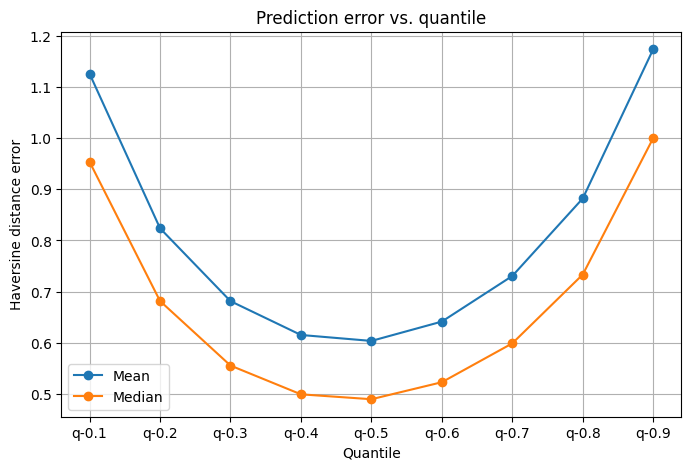

In [37]:
plt.figure(figsize=(8,5))
plt.plot(df_stats["quantile"], df_stats["mean"], marker="o", label="Mean")
plt.plot(df_stats["quantile"], df_stats["median"], marker="o", label="Median")
plt.xlabel("Quantile")
plt.ylabel("Haversine distance error")
plt.title("Prediction error vs. quantile")
plt.legend()
plt.grid(True)
plt.show()